# COVID and Cognition

The data we will analyse today consists of the performance of 50 COVID-19 patients in three cognitive tasks, called target detection, spatial Span and verbal Analogies. Our aim is to understand whether patients' cognition was affected by COVID-19 and whether the type of symptoms and the gravity of the disease (e.g. whether participants ended up in intensive care units) played a role on the level of cognitive changes that occurred. 

Each one of the cognitive tasks completed by patients measures different aspects of cognition: 

1. **Target detection:** attention task, it measures the ability to identify specific *relevant* information in the context of many distractors. The task is designed to be particularly challenging due to the rate at which targets and distractors appear in the array, which requires participants to continously pay attention in order to avoid missing targets and losing points. 
2. **Spatial Span:** memory task, participants are presented with a 4 x 4 grid, onto which is displayed a sequence of squares in different positions in the grid. They must then click the squares in the order that they were highlighted. Every time a sequence is recalled correctly, the length of the subsequent sequence is incremented by one.
3. **Verbal analogies:** language task, abilities. In this version of the test, participants are presented with two written relationships that they must decide have the same type of association or not. Participants must indicate their decision by selecting the True or False buttons presented below the written analogies.

The performance in cognitive tasks is measured in two ways:

1. Accuracy, that corresponds to the number of correct answers given
2. Reaction time (RT), that correspods to the median or mean time required by participants to complete a trial of each cognitive task.

A small representation of the different tasks is presented in the following Figure.

Verbal Analogies |  Target detection | Spatial Span |
:-------------------------:|:-------------------------: |:-------------------------: |
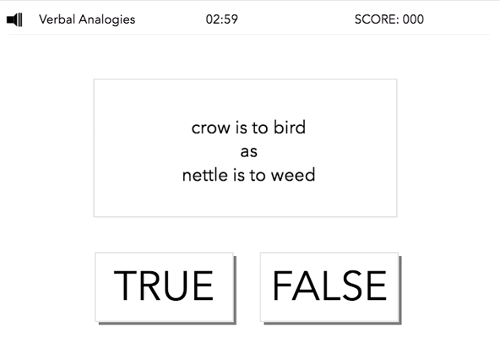 | 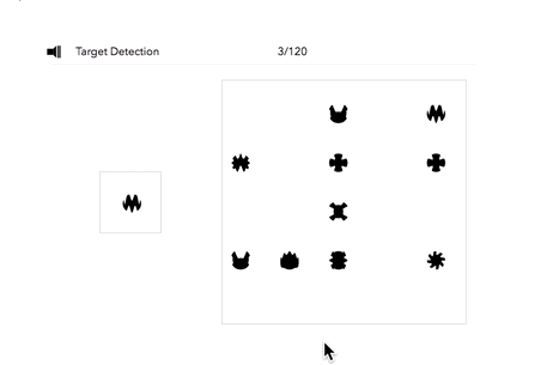|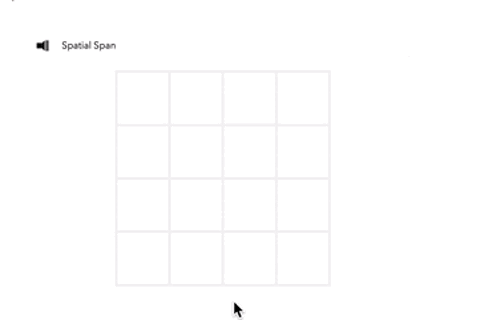

Now that we know our research aim and the description of the cognitive assessment, we can continue with the next steps, namely the data cleaning and analysis. 

Let us first import the libraries we will need for today's workshop and install any new ones.

In [533]:
pip install seaborn

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [534]:
pip install openpyxl

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [535]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import seaborn as sb
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

sb.set_theme("talk")
sb.set_style("whitegrid")

Now let's open the data file as a dataframe. Note that so far we have worked with `.csv` files but Python can just as easily open and manipulate other file types like `excel`. Have a quick look at your data 

In [536]:
df = pd.read_excel("Data/covid_dataset.xlsx")
df.head(10)

,Unnamed: 0,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,Symtpm onset,tested date,COVID Symptom onset to imaging & cognitive testing (days),Admission to imaging & cognitive testing (days),Covid-19 severity (WHO Ordinal Scale),"Mechanical ventilation (1-Y,0-no)",Days mechanically ventilated,Trachy Y/N,"Lowest PaO2/FiO2 ratio (severity of lung injury, lower is worse)",Extrapulmonary organ dysfunction/support,Highest CRP during admission,Highest D-Dimer during admission,GAD-7,PHQ-9,PCL-5,GAD7 1.,GAD7 2.,GAD7 3.,GAD7 4.,GAD7 5.,GAD7 6.,GAD7 7.,PHQ9 1.,PHQ9 2.,PHQ9 3.,PHQ9 4.,PHQ9 5.,PHQ9 6.,PHQ9 7.,PHQ9 8.,PHQ9 9.,PHQ9 Difficulty,PCL5 1.,PCL5 2.,PCL5 3.,PCL5 4.,PCL5 5.,PCL5 6.,PCL5 7.,PCL5 8.,PCL5 9.,PCL5 10.,PCL5 11.,PCL5 12.,PCL5 13.,PCL5 14.,PCL5 15.,PCL5 16.,PCL5 17.,PCL5 18.,PCL5 19.,PCL5 20.,DRI_fourTowers,rs_TOL,rs_learningCurves,rs_manipulations2D,rs_motorControl,rs_prospectiveMemoryWords_1_delayed,rs_prospectiveMemoryWords_1_immediate,rs_spatialSpan,rs_targetDetection,rs_verbalAnalogies,RTDRI_fourTowers,RTrs_learningCurves,RTrs_manipulations2D,RTrs_TOL,RTrs_motorControl,RTrs_prospectiveMemoryWords_1_delayed,RTrs_prospectiveMemoryWords_1_immediate,RTrs_spatialSpan,RTrs_targetDetection,RTrs_verbalAnalogies
0,0,4133880.0,"""63""",2,Right,"Some college, no degree",Polish,Other,2020-05-05,NaT,38,34,6,1,14,N,8.0,Y,286,242,4,3,21,1.0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1,1,3.0,3.0,1,1.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1,0.0,1.0,2.0,2.0,3.0,106.0,17.0,659.03,21.0,22.0,4.0,65.0,6.0,10242.0,50.764,4504.0,13709.0,13.0790,1041.0,1113.0,4245.5,1314.0,9054.0
1,1,4227668.0,"""70""",1,Right,O levels/GCSEs,English,english,2020-03-18,NaT,87,65,7,1,47,Y,10.0,Y,350,11593,1,0,5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,6.0,8.0,118.0,17.0,733.57,19.0,22.0,4.0,32.0,11.0,11151.0,50.551,8262.0,11550.0,23.0550,1010.5,1066.0,2863.0,1686.0,6167.5
2,2,4105609.0,"""54""",1,Right,A levels,English,english,2020-03-22,NaT,97,90,6,1,28,Y,8.0,Y,399,3161,9,9,16,1.0,1,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1,0,0.0,0.0,0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3,0.0,2.0,2.0,10.0,10.0,119.0,18.0,659.67,18.0,22.0,5.0,63.0,8.0,11171.0,50.247,6937.0,9411.0,12.0190,800.5,930.0,2383.0,1079.0,4799.0
3,3,4105207.0,"""55""",2,Right,"Some college, no degree",English,English,2020-03-31,NaT,95,99,7,1,18,N,10.0,Y,405,861,4,5,13,0.0,1,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,0.0,2,0.0,2.0,2.0,-4.0,8.0,105.0,8.0,1041.30,21.0,18.0,5.0,35.0,21.0,12665.0,50.618,16940.0,11868.0,8.2759,1005.0,1676.5,2642.0,2030.5,3017.0
4,4,4239617.0,"""71""",1,Right,Doctoral degree,English,English,2020-03-10,NaT,121,111,7,1,50,Y,9.5,Y,367,952,0,0,3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1,0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,10.0,9.0,120.0,24.0,786.40,20.0,24.0,6.0,64.0,38.0,8612.5,50.792,4809.5,7010.0,28.4730,1010.0,999.0,5343.5,1376.5,3247.0
5,5,4303013.0,"""34""",2,Left,A levels,English,English,2020-04-22,NaT,93,16,5,0,0,N,NaN,N,281,235,15,11,39,2.0,1,3.0,2.0,1.0,3.0,3.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,3.0,2.0,3.0,2,3,3.0,2.0,1,3.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1,1.0,2.0,3.0,2.0,8.0,120.0,31.0,731.57,15.0,19.0,4.0,56.0,9.0,11621.0,50.539,3961.0,8700.5,14.9220,1298.0,1079.5,5281.0,1349.0,4610.0
6,6,3928857.0,"""61""",1,Left,Not done,English,English,2020-03-12,NaT,133,123,7,1,9,Y,8.5,Y,391,2985,13,10,6,2.0,2,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,1.0,3.0,2.0,2.0,2,3,2.0,2.0,3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1.0,2.0,2.0,2.0,7.0,118.0,19.0,575.67,19.0,20.0,5.0,38.0,3.0,21358.0,50.958,5902.0,15116.0,14.8830,729.0,846.5,5177.0,2259.0,3963.0
7,7,3929051.0,"""68""",1,NaN,Not done,English,English,2020-03-28,2020-08-07,132,not scanned,6,1,18,Y,12.

Notice that not all columns are shown, as Python has a cap on how many columns it can show in a table. To help us visualise the data better, we will remove that cap.

In [537]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,Symtpm onset,tested date,COVID Symptom onset to imaging & cognitive testing (days),Admission to imaging & cognitive testing (days),Covid-19 severity (WHO Ordinal Scale),"Mechanical ventilation (1-Y,0-no)",Days mechanically ventilated,Trachy Y/N,"Lowest PaO2/FiO2 ratio (severity of lung injury, lower is worse)",Extrapulmonary organ dysfunction/support,Highest CRP during admission,Highest D-Dimer during admission,GAD-7,PHQ-9,PCL-5,GAD7 1.,GAD7 2.,GAD7 3.,GAD7 4.,GAD7 5.,GAD7 6.,GAD7 7.,PHQ9 1.,PHQ9 2.,PHQ9 3.,PHQ9 4.,PHQ9 5.,PHQ9 6.,PHQ9 7.,PHQ9 8.,PHQ9 9.,PHQ9 Difficulty,PCL5 1.,PCL5 2.,PCL5 3.,PCL5 4.,PCL5 5.,PCL5 6.,PCL5 7.,PCL5 8.,PCL5 9.,PCL5 10.,PCL5 11.,PCL5 12.,PCL5 13.,PCL5 14.,PCL5 15.,PCL5 16.,PCL5 17.,PCL5 18.,PCL5 19.,PCL5 20.,DRI_fourTowers,rs_TOL,rs_learningCurves,rs_manipulations2D,rs_motorControl,rs_prospectiveMemoryWords_1_delayed,rs_prospectiveMemoryWords_1_immediate,rs_spatialSpan,rs_targetDetection,rs_verbalAnalogies,RTDRI_fourTowers,RTrs_learningCurves,RTrs_manipulations2D,RTrs_TOL,RTrs_motorControl,RTrs_prospectiveMemoryWords_1_delayed,RTrs_prospectiveMemoryWords_1_immediate,RTrs_spatialSpan,RTrs_targetDetection,RTrs_verbalAnalogies
0,0,4133880.0,"""63""",2,Right,"Some college, no degree",Polish,Other,2020-05-05,NaT,38,34,6,1,14,N,8.0,Y,286,242,4,3,21,1.0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1,1,3.0,3.0,1,1.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1,0.0,1.0,2.0,2.0,3.0,106.0,17.0,659.03,21.0,22.0,4.0,65.0,6.0,10242.0,50.764,4504.0,13709.0,13.0790,1041.0,1113.0,4245.5,1314.0,9054.0
1,1,4227668.0,"""70""",1,Right,O levels/GCSEs,English,english,2020-03-18,NaT,87,65,7,1,47,Y,10.0,Y,350,11593,1,0,5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,6.0,8.0,118.0,17.0,733.57,19.0,22.0,4.0,32.0,11.0,11151.0,50.551,8262.0,11550.0,23.0550,1010.5,1066.0,2863.0,1686.0,6167.5
2,2,4105609.0,"""54""",1,Right,A levels,English,english,2020-03-22,NaT,97,90,6,1,28,Y,8.0,Y,399,3161,9,9,16,1.0,1,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1,0,0.0,0.0,0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3,0.0,2.0,2.0,10.0,10.0,119.0,18.0,659.67,18.0,22.0,5.0,63.0,8.0,11171.0,50.247,6937.0,9411.0,12.0190,800.5,930.0,2383.0,1079.0,4799.0
3,3,4105207.0,"""55""",2,Right,"Some college, no degree",English,English,2020-03-31,NaT,95,99,7,1,18,N,10.0,Y,405,861,4,5,13,0.0,1,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,0.0,2,0.0,2.0,2.0,-4.0,8.0,105.0,8.0,1041.30,21.0,18.0,5.0,35.0,21.0,12665.0,50.618,16940.0,11868.0,8.2759,1005.0,1676.5,2642.0,2030.5,3017.0
4,4,4239617.0,"""71""",1,Right,Doctoral degree,English,English,2020-03-10,NaT,121,111,7,1,50,Y,9.5,Y,367,952,0,0,3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1,0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,10.0,9.0,120.0,24.0,786.40,20.0,24.0,6.0,64.0,38.0,8612.5,50.792,4809.5,7010.0,28.4730,1010.0,999.0,5343.5,1376.5,3247.0


Now you can see all 79 columns. Please go through each column and try to understand what it is that they are measuring.

**HINT**: there are two different columns that have scores for the three tasks of interest. These scores represent two different things, namely the accuracy and the median RT. If patients are impaired, then we expect their accuracy to be lower compared to healthy participants, and their RT to be higher, because participants need longer times to complete the same tasks..

There is a lot of information contained in this dataset. But for today's tutorial we do not need all of this information. Let's try to curate a smaller dataset which only contains the variables that we are interested in. We are going to keep several demographic variables, some information about COVID19 severity and the accuracy results of 3 cognitive tasks.

In [538]:
df2 = pd.concat([df.loc[:, "userID":"First Language binary"], 
                 df["Mechanical ventilation (1-Y,0-no)"], 
                 df.loc[:, "rs_spatialSpan":"rs_verbalAnalogies"]], axis=1)

In [539]:
df2.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,"Mechanical ventilation (1-Y,0-no)",rs_spatialSpan,rs_targetDetection,rs_verbalAnalogies
0,4133880.0,"""63""",2,Right,"Some college, no degree",Polish,Other,1,4.0,65.0,6.0
1,4227668.0,"""70""",1,Right,O levels/GCSEs,English,english,1,4.0,32.0,11.0
2,4105609.0,"""54""",1,Right,A levels,English,english,1,5.0,63.0,8.0
3,4105207.0,"""55""",2,Right,"Some college, no degree",English,English,1,5.0,35.0,21.0
4,4239617.0,"""71""",1,Right,Doctoral degree,English,English,1,6.0,64.0,38.0


Our dataset looks a lot more manageable now! However, some of the variable names we have are not very intuitive. Let's change the name of the cognitive tasks so that it is easier to understand what they measure.

In [540]:
df2.rename(columns = {'rs_spatialSpan':'memory_spatialSpan', 
                      'rs_verbalAnalogies':'language_verbalAnalogies', 
                      'rs_targetDetection':'attention_targetDetection'}, inplace = True)
df2.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,"Mechanical ventilation (1-Y,0-no)",memory_spatialSpan,attention_targetDetection,language_verbalAnalogies
0,4133880.0,"""63""",2,Right,"Some college, no degree",Polish,Other,1,4.0,65.0,6.0
1,4227668.0,"""70""",1,Right,O levels/GCSEs,English,english,1,4.0,32.0,11.0
2,4105609.0,"""54""",1,Right,A levels,English,english,1,5.0,63.0,8.0
3,4105207.0,"""55""",2,Right,"Some college, no degree",English,English,1,5.0,35.0,21.0
4,4239617.0,"""71""",1,Right,Doctoral degree,English,English,1,6.0,64.0,38.0


Try to change the column called `Qualifications` to `Education`

In [541]:
#CODE HERE

Now, let's look at the data types for each of our variables. We discussed these during the primer, but as a quick summary, it is important that the data type matches what we expect. Strings are usually saved as objects in python and numeric variables are saved as integers (int64) or float (float64). However, sometimes either due to humar error or due to the way the data is saved, Python might assign the wrong data type to your variables (e.g. numbers may be saved as strings). When this happens, statistical tests throw errors and so do certain plotting functions and it can take a while to figure out where the errors come from. Have a look at our data and see if you can spot any wrong data types.

In [542]:
df2.dtypes

userID                               float64
Age                                   object
Sex 1-Male 2-Female                    int64
Handedness                            object
Qualifications                        object
First Language                        object
First Language binary                 object
Mechanical ventilation (1-Y,0-no)      int64
memory_spatialSpan                   float64
attention_targetDetection            float64
language_verbalAnalogies             float64
dtype: object

It looks like Age was saved as an object, instead of integer. Let's change that. First, we get rid of the quotation marks around the numbers, then we tell python to convert those numbers to `int`

In [543]:
df2.Age = df["Age"].str.strip('\"') 


In [544]:
df2.Age = df2.Age.astype(int)

In [545]:
df2.dtypes # check that the changes have worked

userID                               float64
Age                                    int64
Sex 1-Male 2-Female                    int64
Handedness                            object
Qualifications                        object
First Language                        object
First Language binary                 object
Mechanical ventilation (1-Y,0-no)      int64
memory_spatialSpan                   float64
attention_targetDetection            float64
language_verbalAnalogies             float64
dtype: object

Now that we have all of our data in the right format, we may want to check if the values contained in the columns are consistent. If you have a look in the `First language binary` column you will notice that some of the values are capitalised while others are not. This is a problem as any statistics we run will assume that `english` and `English` are two distinct groups. To fix this, we can choose a consistent way to show this and stick with it.

In [546]:
df2['First Language binary'] = df2['First Language binary'].str.title()
df2.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,"Mechanical ventilation (1-Y,0-no)",memory_spatialSpan,attention_targetDetection,language_verbalAnalogies
0,4133880.0,63,2,Right,"Some college, no degree",Polish,Other,1,4.0,65.0,6.0
1,4227668.0,70,1,Right,O levels/GCSEs,English,English,1,4.0,32.0,11.0
2,4105609.0,54,1,Right,A levels,English,English,1,5.0,63.0,8.0
3,4105207.0,55,2,Right,"Some college, no degree",English,English,1,5.0,35.0,21.0
4,4239617.0,71,1,Right,Doctoral degree,English,English,1,6.0,64.0,38.0


Try to do the same for the `Handedness` variable.

In [547]:
#CODE HERE

We may also wish to encode some of our categorical variables into a numeric format. This is usually done as specific statistical techniques, as well as machine learning algorithms (which we will discuss in later lectures), require categorical data to be in a numeric format. So, it is always safer to have your data saved in a numeric format, wherever possible. 

There are different ways to encode variables, and the two most common ones are `integer encoding` and `one-hot-encoding`. Integer encoding consists in assigning an integer value to each category. Instead, one-hot encoding represents categorical variables as binary vectors. Concretely if you have three potential alternatives for one category, then, for each participant, the proper alternative will be assigned a vlue of 1, and the others a value of 0. 

Both integer and one-hot encoding can be used. However, one limitation of integer encoding is that it introduces an *order* when assigning an integer to each group, which might not really be meaningful. So, it should be used carefully, based on the type of anaysis that you want to do.

The language variable is a good example where `one-hot-encoding` encoding would be useful. Let's see how this can be done below.

The most common way to one-hot-encode in Python is to use the `get_dummies` function. If you want to see further examples of this, we have some in our primer.

In [548]:
# Text Data of First Language is converted into Numeric Binary Data
df_one = pd.get_dummies(df2['First Language binary'])
df_one.head()
df_one.shape

(50, 2)

On the other hand, if you prefer to integer encode there are mutliple approaches that can be used. The first way is to define a dictionary on your own, in order to be able to decide which integer is assigned to which feature. Below, we assign value one to all the fields which have `English` in them and value zero to those with `Other`

In [549]:
mapping_language = {"English": 1, "Other": 0}
mapped_language = df2['First Language binary'].map(mapping_language)
mapped_language.head()

0    0
1    1
2    1
3    1
4    1
Name: First Language binary, dtype: int64

Based on whether you choose to one-hot encode or integer encode your features, you will need to conduct your analysis slightly differently, mainly when training regression models. Whether you should one-hot-encode or integer encode mainly depends on the type of analysis you need to conduct. In this case, integer encoding is enough. 

In [550]:
df2['First Language binary'] = mapped_language

Let's now rename the column into an easy-to-understand name

In [551]:
df2.rename(columns = {'First Language binary':'First Language 1-English 0-Other'}, inplace = True)
df2.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language 1-English 0-Other,"Mechanical ventilation (1-Y,0-no)",memory_spatialSpan,attention_targetDetection,language_verbalAnalogies
0,4133880.0,63,2,Right,"Some college, no degree",Polish,0,1,4.0,65.0,6.0
1,4227668.0,70,1,Right,O levels/GCSEs,English,1,1,4.0,32.0,11.0
2,4105609.0,54,1,Right,A levels,English,1,1,5.0,63.0,8.0
3,4105207.0,55,2,Right,"Some college, no degree",English,1,1,5.0,35.0,21.0
4,4239617.0,71,1,Right,Doctoral degree,English,1,1,6.0,64.0,38.0


Try to do apply the same concept of encoding to the `Handedness` variable. Sex is already encoded for you, so you don't need to do it.

In [552]:
#CODE HERE

Now, before moving forward we may also want to check the validity of the data. Are there any odd values that are not within the expected range? The best way to examine this is via plotting. Let's visualise some of the variables in the dataset

Text(0.5, 1.0, 'Accuracy Spatial Span')

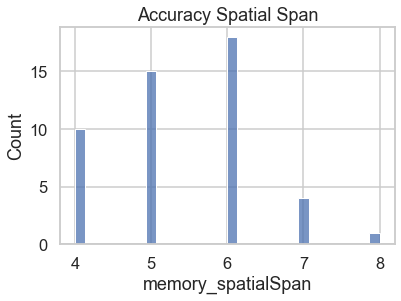

In [553]:
_ = sb.histplot(data = df2, x = "memory_spatialSpan", bins = 30)
plt.title("Accuracy Spatial Span")

Text(0.5, 1.0, 'Accuracy Target detection')

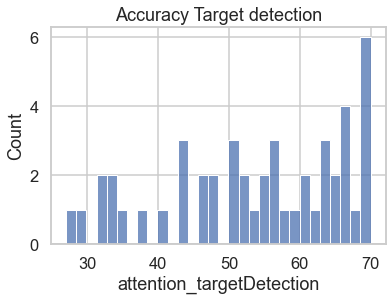

In [554]:
_ = sb.histplot(data = df2, x = "attention_targetDetection", bins = 30)
plt.title("Accuracy Target detection")

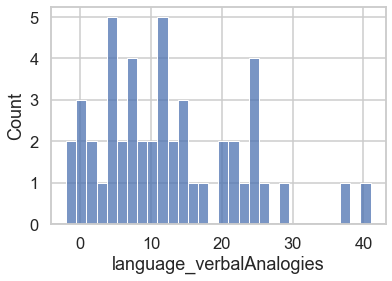

In [555]:
_ = sb.histplot(data = df2, x = "language_verbalAnalogies", bins = 30)

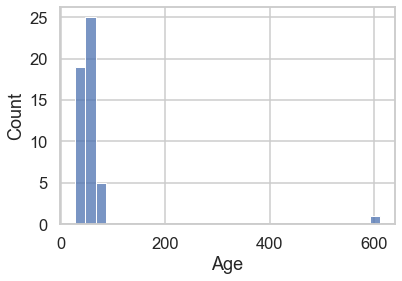

In [556]:
_ = sb.histplot(data = df2, x = "Age", bins = 30)

We see that for the cognitive variables the data looks valid. However, when we look at age, one person seems to be over 600 years old! Unless we are dealing with a vampire, we may want to do something about this data. There are multiple ways to deal with this type of data but the simplest and most straightforward is to get rid of it, by replacing it with a NaN value.

40    610
Name: Age, dtype: int64


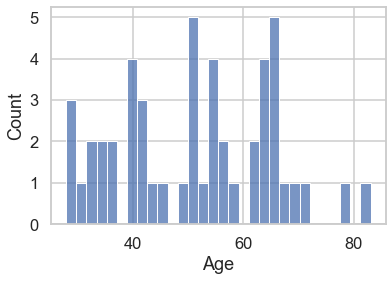

In [557]:
print(df2.Age[df2.Age > 100]) #show all the people who had an age over 100
df2.Age.loc[df2.Age > 100] = np.nan  #replace with NaNs anyone who is older than 100
_ = sb.histplot(data = df2, x = "Age", bins = 30) #plot the new data


Check for the remaining variables if there is any data that is not valid. If you find anything, replace it with NaNs

Now that we have established that the data looks healthy, the next thing on the list is to check whether there are any duplicated values in our dataset. The easiest way to check this is via the number of unique user IDs. If we had no duplicates, then the number of unique IDs should correspond with the total number of rows in our data.

In [558]:
print(len(np.unique(df2.userID)))
print(len(df2.userID))

48
50


You can also use the `duplicated` function to obtain the same results.

In [559]:
sum(df2.duplicated()) 

2

It looks like we got two duplicates in our data. Let us try to remove them.

In [560]:
df2 = df2[~df2.duplicated()] #Have a look at lecture 8 if you don't remember this function
sum(df2.duplicated()) # calculate the number of duplicates again after removing them. If we were succcessful none should be there anymore.

0

We are almost done cleaning our data. Now let's check if there are any missing values. It's generally good practice to get rid of participants with missing data or replace those values with plausible estimates (like the mean/median). In this case, we will show the first. To find out if we have any missing values we can use the `isna` function. This returns True when there is a missing value and False when there isn't one.

In [561]:
df2.isna().sum()

userID                               1
Age                                  1
Sex 1-Male 2-Female                  0
Handedness                           1
Qualifications                       0
First Language                       0
First Language 1-English 0-Other     0
Mechanical ventilation (1-Y,0-no)    0
memory_spatialSpan                   2
attention_targetDetection            2
language_verbalAnalogies             2
dtype: int64

Let's try to understand how many different people have missing values among the 50 participants. 

In [562]:
sum_missing = df2.isna().sum(axis=1) #This shows us how many missing values each person has
print(sum(sum_missing > 0)) #how many people have at least one missing data


3


Let's get rid of the 3 people who have at least one missing value

In [563]:
df2 = df2[~(sum_missing > 0)]

Another important check we need to perform is to look for outliers. These are often less easy to spot and sometimes it is unclear if one value is an outlier or not. Some may remove more extreme values only because it helps with their hypothesis, creating bias. Just because a value is extreme it does not always mean that it is wrong. However, if you don't do something about your outliers, they will likely bias your results and your data.

One robust, objective way to deal with outliers is via a process called winsorisation. This approach replaces the extreme values in our data with slightly less extreme values, in order to limit the effect of the outliers on the calculations or the results. The mean value calculated after such replacement of the extreme values is called winsorized mean. 

For example, 90% winsorization means the replacement of the top 5% and bottom 5% of the data. The top 5% of the data is replaced by the value of the data at the 95th percentile and the value of the bottom 5% of the data is replaced by the value of the data at the 5th percentile. 

Let's see if our cognitive data requires any winsorisation by visualising it.

(array([1, 2, 3]),
 [Text(1, 0, 'Verbal Analogies'),
  Text(2, 0, 'Spatial Span'),
  Text(3, 0, 'Target Detection')])

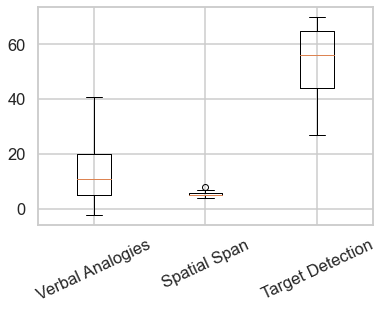

In [564]:
_ = plt.boxplot([df2.language_verbalAnalogies, df2.memory_spatialSpan, df2.attention_targetDetection], 
               labels = ["Verbal Analogies", "Spatial Span", "Target Detection"])
plt.xticks(rotation=25)

The scales are really different, so it is not really easy to visualise Spatial Span. However, we can see that it looks like there is an outlier. Let's plot spatial span alone to check more in detail. 

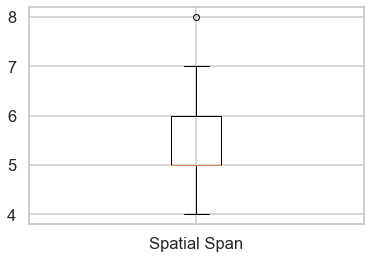

In [565]:
_ = plt.boxplot(df2.memory_spatialSpan, labels = ["Spatial Span"])

Looking at the box plot, we can see that for the memory Spatial Span task, we have one person who performed really well. A score of 8 is plausible within this task, but not very common. For that reason, it is not valid for us to just remove it. Instead, let us apply the winsorisation procedure to replace the value with something a bit less extreme by replacing the values above the 95th percentile with the value of the score on the 95th percentile.

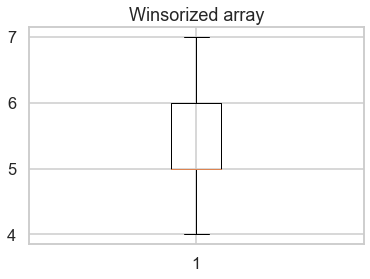

In [566]:
winsorized_memory = winsorize(df2['memory_spatialSpan'],(0.05,0.05))  #apply winsorisation
  
plt.boxplot(winsorized_memory)  #visualise the data after winsorisation
plt.title('Winsorized array')
plt.show()

It now looks a lot better! Let's replace the old values in the memory task with the winsorised version.

In [567]:
df2['memory_spatialSpan'] = winsorized_memory

One final check, now that the data is in the right format and we are confident that it is correct, is to ensure everything is on the same scale. Different tasks will have different scoring mechanisms. While on some tasks the scores may range from 4 to 8, in others they may range between 30 and 70. This is often a problem as depending on the statistical test you use, if one variable has very large values, it will dominate over other variables. So the features with higher variability may receive more weight than the others even though in theory they should not.

To scale the features, there are two options that can be completed:

1. **Standardisation**: scale numbers based on the mean and standard deviation
2. **Normalisation**: scale the numbers between 0 and 1. 

To`standardise` features, we can use the following equation.

$$featureScaled = \frac{feature - \mu_{feature}}{\sigma_{feature}} $$

Where $\mu_{feature}$ correspnds to the mean of the feature and $\sigma_{feature}$ to its standard deviation.

Instead, to complete data `normalisation`, we can use the following equation:

$$ featureNormalised = \frac{feature - {feature}_{MIN}}{feature_{MAX} - feature_{MIN}} $$

`standardisation` is a bit more robust towards outliers compared to `normalisation`, and the latter tends to be used when the data don't follow a Gaussian distribution. **But this is not a rule.** You can use standardisation even if your data are not normally distributed, and the choice of feature scaling really depends on your analysis. 

In this case, we want to evaluate at the end how much the performance of patients deviates from the performance of healthy controls in terms of standard deviation units. This is why using standardisation, which scales the values accoridng to mean and std is more appropriate. However, there is an issue. If we standardise the patients and healthy controls separately, then we will end up using two different means and standard deviations, which will make their performances uncomparable. This is why we need to standardise the patients score in each cognitive tasks with the respective mean and standard deviation of the healthy controls scores.

Let's read the healthy controls data.

In [570]:
df_healthy = pd.read_excel('Data/demographics_day2.xlsx')
df_healthy.shape

(15722, 22)

As you can see the healthy dataset contains 15722 rows and 15 columns. Each row has data of one healthy participant, and contains their performance in the three cognitive tasks of interest as well as their demographics. The healthy participants were selected in such a way that there were at least 50 people for each possible combination of demographics, and the cognitive scores were already cleaned from the biggest outliers.

Have a look at the variables.

In [571]:
df_healthy.head()

,SummaryScore_SpatialSpan,RT_SpatialSpan,user_id,SummaryScore_targetDetection,RT_targetDetection,SummaryScore_VerbalAnalogies,RT_VerbalAnalogies,Residence,Language binary,Ethnicity,Sex,Education,Handedness,Occupation,Salary,timepoint_by_date,Age,Imputation,Device Summary,Normative,Age squared,Age decade
0,8,5414.0,fc9b0048ab9e40a9aa823e195bd12043,49,1916.0,4,4722.0,United States,English,American Hispanic,Female,00_preGCSE,Right handed,Worker,Â£40-50K,tp1,27,0,Apple phone,0,729,20
1,7,3066.5,87f080fe66374700a2b54c350a560d20,71,886.0,16,3045.0,United Kingdom,English,American Hispanic,Female,00_preGCSE,Right handed,Worker,Â£10-20K,tp1,27,0,Android phone,0,729,20
2,7,2366.0,3c20040d-c5a7-4394-b7b4-daa04ca5f240,62,1303.0,22,2355.0,United Kingdom,English,American Hispanic,Female,00_preGCSE,Right handed,Worker,Â£0-10K,tp1,28,0,Apple phone,0,784,20
3,6,3332.5,3edc12d8ead348b094782ca9b74f8446,48,876.5,-9,4751.5,United Kingdom,English,American Hispanic,Female,00_preGCSE,Left handed,Worker,Â£30-40K,tp1,36,0,Apple phone,0,1296,30
4,5,1591.5,b1cc65d5aaa44aecb557747438897a41,43,2017.0,4,2597.0,United Kingdom,English,American Hispanic,Female,00_preGCSE,Right handed,Worker,Â£40-50K,tp1,38,0,Apple phone,0,1444,30


Notice there are quite a few we don't need, so we will just select the variables that we want to compare against the patients.

In [572]:
dfH = df_healthy[['SummaryScore_SpatialSpan', 'SummaryScore_VerbalAnalogies', 'SummaryScore_targetDetection', 'Age', 'Sex', 'Language binary']]

In [573]:
dfH.head()

,SummaryScore_SpatialSpan,SummaryScore_VerbalAnalogies,SummaryScore_targetDetection,Age,Sex,Language binary
0,8,4,49,27,Female,English
1,7,16,71,27,Female,English
2,7,22,62,28,Female,English
3,6,-9,48,36,Female,English
4,5,4,43,38,Female,English


Let's now try to plot the distributions of the scores in the three cognitive tasks to see how they look

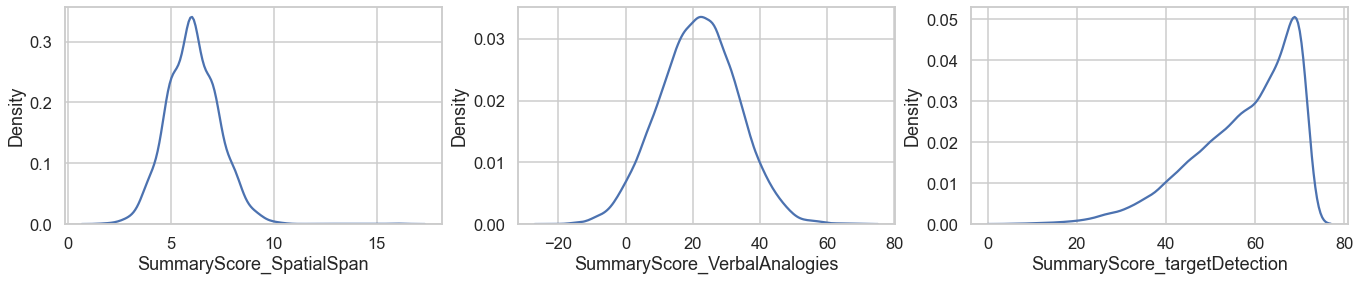

In [574]:
plt.figure(figsize = (23, 4))
plt.subplot(131)
_ = sb.kdeplot(dfH.SummaryScore_SpatialSpan, bw_adjust=2.5)
plt.subplot(132)
_ = sb.kdeplot(dfH.SummaryScore_VerbalAnalogies)
plt.subplot(133)
_ = sb.kdeplot(dfH.SummaryScore_targetDetection)

As expected, it appears that the majority of the people perform more or less average, with just few people having really high or low socres. However, target detection appears to have a longer lower tail. Now that we have the healthy control data, we can use their mean and standard deviation to scale the patients and control data.

In [575]:
memory_task = (df2['memory_spatialSpan'] - dfH['SummaryScore_SpatialSpan'].mean())/dfH['SummaryScore_SpatialSpan'].std()
language_task = (df2['language_verbalAnalogies'] - dfH['SummaryScore_VerbalAnalogies'].mean())/dfH['SummaryScore_VerbalAnalogies'].std()
attention_task = (df2['attention_targetDetection'] - dfH['SummaryScore_targetDetection'].mean())/dfH['SummaryScore_targetDetection'].std()

In [576]:
memory_task_control = (dfH['SummaryScore_SpatialSpan'] - dfH['SummaryScore_SpatialSpan'].mean())/dfH['SummaryScore_SpatialSpan'].std()
language_task_control = (dfH['SummaryScore_VerbalAnalogies'] - dfH['SummaryScore_VerbalAnalogies'].mean())/dfH['SummaryScore_VerbalAnalogies'].std()
attention_task_control = (dfH['SummaryScore_targetDetection'] - dfH['SummaryScore_targetDetection'].mean())/dfH['SummaryScore_targetDetection'].std()

In the above code we subtracted the mean values and divided by the standard deviation, to obtain standardised values. Then, we old values with the standardised ones. We can visualise these changes to better understand how our data looks now.

Text(0.5, 1.0, 'Healthy controls - Performance after scaling')

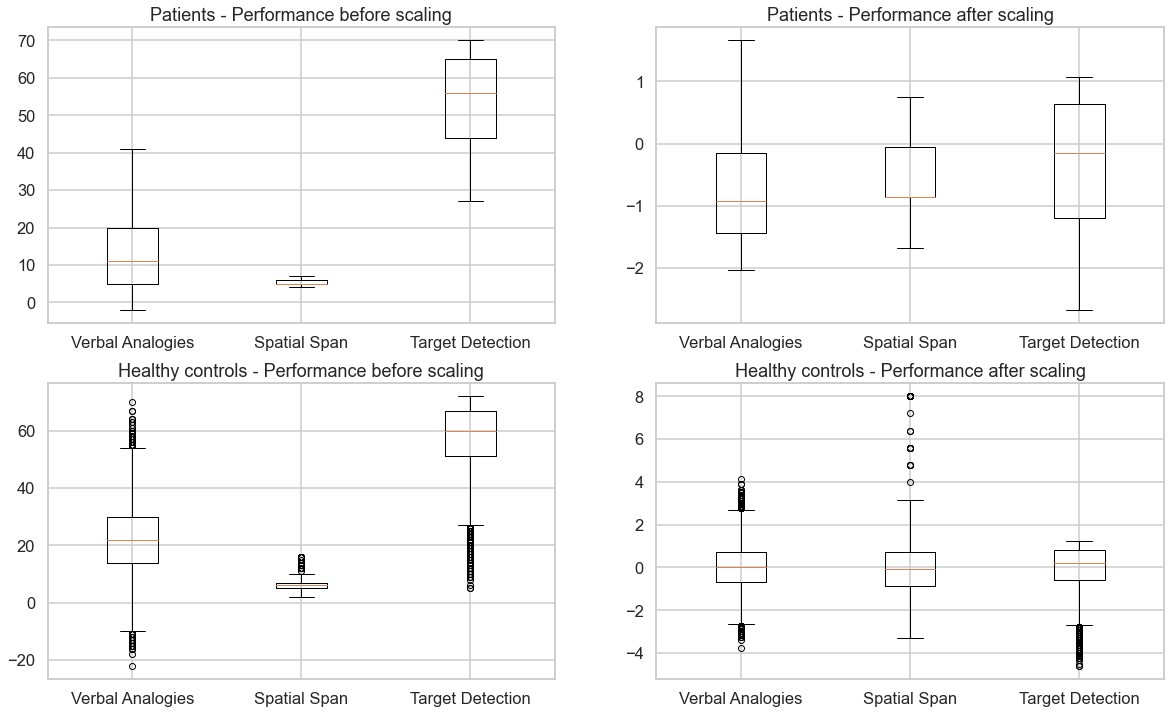

In [580]:
plt.figure(figsize = (20, 12))
plt.subplot(221)
_ = plt.boxplot([df2.language_verbalAnalogies, df2.memory_spatialSpan, df2.attention_targetDetection], 
               labels = ["Verbal Analogies", "Spatial Span", "Target Detection"])
plt.title("Patients - Performance before scaling")
plt.subplot(222)
_ = plt.boxplot([language_task, memory_task, attention_task], labels = ["Verbal Analogies", "Spatial Span", "Target Detection"])
plt.title("Patients - Performance after scaling")
plt.subplot(223)
_ = plt.boxplot([dfH['SummaryScore_VerbalAnalogies'], dfH['SummaryScore_SpatialSpan'] , dfH['SummaryScore_targetDetection']],
                labels = ["Verbal Analogies", "Spatial Span", "Target Detection"])
plt.title("Healthy controls - Performance before scaling")
plt.subplot(224)
_ = plt.boxplot([language_task_control, memory_task_control, attention_task_control], labels = ["Verbal Analogies", "Spatial Span", "Target Detection"])
plt.title("Healthy controls - Performance after scaling")


As you can see, in case of healthy controls, the data have now, more or less, a mean of 0 and std of 1. However, this is not exactly the same for patients. The reason is that patients tend to be impaired. If we had used different means, these impairment would have been hidden!!

Let's now replace the values in the original dataframe with the scaled ones, both for healthy and patients. We could have replaced the values directly above, but we preferred not to do it in order to be able to create the boxplots and observe the changes before and after the feature scaling.

In [ ]:
df2['memory_spatialSpan'] = memory_task
df2['language_verbalAnalogies'] = language_task
df2['attention_targetDetection'] = attention_task

dfH['memory_spatialSpan'] = memory_task_control
dfH['language_verbalAnalogies'] = language_task_control
dfH['attention_targetDetection'] = attention_task_control

By doing this, we created three new columns in the healthy control dataset with the same column names as the patients, and containing the scaled features. We can now remove the old columns. 

In [ ]:
dfH = dfH.drop(["SummaryScore_VerbalAnalogies", 'SummaryScore_SpatialSpan', 'SummaryScore_targetDetection'], axis = 1)
dfH.head()

,Age,Sex,Language binary,memory_spatialSpan,language_verbalAnalogies,attention_targetDetection
0,27,Female,English,1.551192,-1.518426,-0.759205
1,27,Female,English,0.744876,-0.488172,1.157225
2,28,Female,English,0.744876,0.026954,0.373231
3,36,Female,English,-0.061440,-2.634534,-0.846316
4,38,Female,English,-0.867757,-1.518426,-1.281868


This was the last data cleaning step for the patients, let's now look into more details on the healthy controls data and their demographics.
If you look carefully, you will notice that some data is saved in different formats (e.g. Sex, Language). Before we can compare the two groups we need to make sure that the two datasets are comparable. This process is commonly known as `harmonization` of data.

Let's first create binary variables for `language` and `sex`, using the same exact encoding of control. Based on the column titles, the sex columns assigned a 1 to males and 2 to females. Let's check which options are available in the healthy control dataset.

**IMPORTANT**: if you assign the wrong integer to the wrong group within each category, all the results will be incorrect.

In [ ]:
dfH.Sex.value_counts(), dfH["Language binary"].value_counts()

(Male      8032
 Female    6694
 Other      996
 Name: Sex, dtype: int64,
 English    11510
 Other       4212
 Name: Language binary, dtype: int64)

Note that `Sex` here has a third option called `Other`. In this case, the variable *Other* can be kept in the dataset because of two reasons. First, we know that patients and healthy participants were asked to complete the same questionnaire, which means that the reason why the group *Other* is not in the patient data is because no participants chose it. If there was an inconsistency between the questions asked to the patients and the participants, the data collection deisgn would be really poor, because it wouldn't allow use to properly compare healthy controls with patients.  
Secondly, since the extra group is in the healthy control it isn't a big issue. However, in the opposite circumstance, there would be no healthy participants to use as reference which would make it impossible to evaluate the changes in cognitive ability of patients that selected *Other* as their sex.

Let's just add a third option for Others.

In [ ]:
mapping_language = {"English": 1, "Other": 0}
mapping_sex = {"Male": 1, "Female": 2, "Other": 3}

mapped_language_control = dfH['Language binary'].map(mapping_language)
mapped_sex_control = dfH['Sex'].map(mapping_sex)

dfH['Language binary'] = mapped_language_control
dfH['Sex'] = mapped_sex_control

Now check if there are any missing values, and if there are remove them. 

In [ ]:
# CODE HERE

Finally we can rename the column names to give a easy-to-understand name that matches with the column names of the patients.

In [ ]:
dfH.rename(columns = {'Language binary':'First Language 1-English 0-Other'}, inplace = True)
dfH.rename(columns = {'Sex':'Sex 1-Male 2-Female'}, inplace = True)
dfH.head()

,Age,Sex 1-Male 2-Female,First Language 1-English 0-Other,memory_spatialSpan,language_verbalAnalogies,attention_targetDetection
0,27,2,1,1.551192,-1.518426,-0.759205
1,27,2,1,0.744876,-0.488172,1.157225
2,28,2,1,0.744876,0.026954,0.373231
3,36,2,1,-0.061440,-2.634534,-0.846316
4,38,2,1,-0.867757,-1.518426,-1.281868


We are finally ready for analysis!

What we will do now is perform an analysis called `Deviation from expected`. This analysis allows us to examine how far from the healthy norm the patients are in each task, with respect to their performance and based on their demographics. The reason why we account for the demographics is because they play a role on the performance of participants. We cannot expect 10 years old children to perform like 50 or 80 years old adults!

Simply put, this analysis trains a linear regression model, using as independent variables the demographics of healthy participants and dependent variables their scores in the cognitive tasks. Essentially what the regression model does is learn how participants are supposed to perform based on their demographics if they were healthy. This model then can be used to predict the performance of the patients. The difference between the predicted performance and the actual performance will be the Deviation from Expected. This deviation from expected is already in standard deviation units, because we standardised our data during the data cleaning.

Let's start to measure the deviation from expected for the `Spatial Span memory task`, using `Age`, `Sex` and `First Language` as predictors.

In [ ]:
linr_model = LinearRegression().fit(dfH[["Age","Sex 1-Male 2-Female","First Language 1-English 0-Other"]], dfH['memory_spatialSpan'])
DT_predict = linr_model.predict(df2[["Age","Sex 1-Male 2-Female","First Language 1-English 0-Other"]]) #Predictions on patient data
print(DT_predict)


[-0.57627557 -0.4896522  -0.12899364 -0.3918963  -0.51219336  0.08146806
 -0.28678176 -0.64389905  0.0738768  -0.2791905  -0.62135789  0.16404143
 -0.39594629 -0.35440524 -0.0537789   0.32182955 -0.24169944 -0.30173166
 -0.66998148 -0.01628784 -0.30173166  0.21671502 -0.06137016 -0.35440524
 -0.61730789 -0.43697862 -0.10645248 -0.57222557  0.00979458 -0.08037005
 -0.78268728 -0.3918963  -0.52714325  0.09995922  0.19012386 -0.14799353
 -0.3769464   0.21671502 -0.03123774  0.36286188  0.1675827  -0.41848745
 -0.28324049 -0.03123774  0.20912375]


In [ ]:
print(linr_model.coef_)

[-0.02254116 -0.24036149  0.00405   ]


Let's now calculate the deviation from expected by looking at the difference between the true score and the predicted score from the model

In [ ]:
deviation_from_expected = df2["memory_spatialSpan"] - DT_predict


Plot to see how patients performed in relation to controls

Text(0.5, 1.0, 'Deviation from expected (sd units) \n Spatial Span')

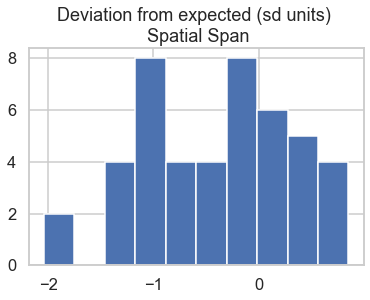

In [ ]:
plt.hist(deviation_from_expected)
plt.title("Deviation from expected (sd units) \n Spatial Span")

From the plot, you can already see that most of the patients have a negative score, which means that their actual performance was lower compared to their predicted performance, which suggests that they are impaired. Let's try to understand what is the mean Deviation from Expected and how many participants had a negative score.

In [ ]:
np.mean(deviation_from_expected)

-0.3907249791349783

In [ ]:
len(deviation_from_expected[deviation_from_expected<0])

31

Let's run a one sample t-test against 0 to examine whether this trend is significant. A sample t-test against zero is run as we expect to see a value of zero if there was absolutely no difference between patients and controls. If the test is significant, then the difference is significantly different from zero.

In [ ]:
# perform one sample t-test
import scipy.stats as stats

t_statistic, p_value = stats.ttest_1samp(a=deviation_from_expected, popmean=0)
print(t_statistic , p_value)

-3.680143064756429 0.0006327664242747124


From this, we can see that patients performed statistically worse than controls on memory tests, as expected!!

-------------
### Code here

Now that we went through the most important aspects of the analysis,let's try to reply to the following questions.

1. Are patients impaired in attention and language? Did the patients perform worse or better?
2. What if we also include education and handedness in our regression model? Perform some harmonisation between the two datasets, such that there are only 3 types of education, pre-bachelor, BSc/MSc and PhD/MD. Then, include these in the regression model and check if your results change.
3. Try to analyse the change in RT. How do the results differ? Why?

In [ ]:
#CODE HERE

--------